### Topic: Gravity model in transport modelling simulations
### Author: Ivana Benova
### Last edits: 03.05.2021

In [1]:
#importation of libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import math
import time
from matplotlib import ticker
import pandas as pd
from scipy.spatial import distance_matrix
from PIL import Image  
import PIL

### Definition of functions

In [2]:
'''Function of matrix entropy
    Inputs: T_2 - numpy array, trip matrix 
    
    Outputs: entropy
    '''
def entropy_function(T_2):
    TT = T_2.copy()
    TT[TT==0]=1
    return -np.sum(T_2*np.log(TT) - T_2) 

In [3]:
'''Calculation of trip matrix constraind by vectors origin and
destination for 20 iterations
    Inputs: T - numpy array, trip matrix,
            D - numpy array, vector of destination,
            O - numpy array, vector of origin
            
    Outputs:T - numpy array, trip matrix after 20 iterations,
            it - integer, number of iterations
            entropy - numpy array, vector of entropies of trip matrix through iterations,
            kvg - numpy array, vector of convergence rate to O and D through iterations'''
def iterate_trip_matrix(T,D,O): 
    entropy = np.array([])
    kvg = np.array([])
    it = 0
    while it<20:
#       iteracia po stlpcoch
        T = np.dot( T, np.diag( np.divide( D, T.sum( axis = 0 ) ) ) )
#       iteracia po riadkoch
        T = np.dot( np.diag( np.divide( O, T.sum( axis = 1 ) ) ), T )
        it += 1
        entropy = np.append(entropy,entropy_function(T))
        kvg = np.append(kvg,np.max( [ np.abs( np.divide( D, T.sum( axis = 0 ) ) - 1 ), \
            np.abs( np.divide( O, T.sum( axis = 1 ) ) - 1 ) ] ))
    return T, it, entropy, kvg

In [4]:
'''Function for calculating the average cost of trips
    Inputs: T - numpy array, matrix of trips,
            c - numpy array, matrix of costs,
            O - numpy array, vector of origin,
            
    Outputs:average cost'''
def average_costs(T,c,O):
    sum = np.sum( T * c )
    return np.array( [ sum / np.sum(O) ] )

In [5]:
'''Deterrance function
    Inputs: p - integer, represents type of function 1-exponential, 2-power, 3-mixed,
            beta - float, parameter of function,
            c - numpy array, matrix of costs,
            
    Outputs:matrix of detterence values'''
def trevel_costs_function(p, beta, c):
    if p == 1:
        f = np.exp( - beta * c )
    elif p == 2:
        f =  c ** ( -beta )
    else:
        f = c * np.exp( - beta * c ) 
    return f

In [6]:
'''Calculation of gravity model, generation of coordinates of zones from normal distribution,
generation of vectors O and D from uniform distribution and 20 iterations of gravity model
    Inputs: seed - integer, random seed,
            n - integer, number of zones,
            alfa - integer, parameter,
            p - integer, represents type of function 1-exponential, 2-power, 3-mixed,
            sigma - integer, variance of normal distribution of zones,
            
    Output: kvg - numpy array, vector of convergence rate to O and D through iterations
            entropy - numpy array, vector of entropies of trip matrix through iterations,
            T - numpy array, trip matrix after 20 iterations'''
def gravity_model( seed, n, alfa, p, sigma):
    
#   Gausove rozdelenie 
    mu = 0
    np.random.seed(seed)
    x = np.random.normal( mu, sigma, n )
    y = np.random.normal( mu, sigma, n )
    
#   matica vzdialenosti (Euklidovska norma)
    df = pd.DataFrame([x,y]).T
    d=distance_matrix(df.values, df.values)
    
#   matica casu (matica vzdialenosti/50km za hod.) 
    t = d / 50
    
#   matica cien
    gama1 = 6
    gama2 = 0.12
    c = gama1 * t + gama2 * d
    
#   velkost miest(pocet obyvatelov)
    O = np.random.uniform(0, 1, n) * 1e5
    D = np.random.uniform(0, 1, n) * 1e5
    D = D*np.sum(O)/np.sum(D)
    
#   zaciatocna hodnota
    beta = 0.05
    
#   krok 2 vypocet trip matrix z initial beta kniha strana 193
#   funkcia f(cij)
    f = trevel_costs_function(p, beta, c)
#   matica T
    T = alfa * f
#   kalkulacia trip matrix
    T, it, entropy, kvg = iterate_trip_matrix( T, D, O )

    return kvg, it, entropy, T

### Simulations

In [7]:
# number of seeds
number_of_seeds = 300
seed = np.round( np.logspace(0, 5, num = number_of_seeds)).astype(int)

#number of zones
number_of_zones = 500

#number of iterations
iterations = 20

In [8]:
m_10_kvg = np.zeros((number_of_seeds,iterations))
m_10_entropia = np.zeros((number_of_seeds,iterations))
m_50_kvg = np.zeros((number_of_seeds,iterations))
m_50_entropia = np.zeros((number_of_seeds,iterations))
m_100_kvg = np.zeros((number_of_seeds,iterations))
m_100_entropia = np.zeros((number_of_seeds,iterations))
m_150_kvg = np.zeros((number_of_seeds,iterations))
m_150_entropia = np.zeros((number_of_seeds,iterations))
T_10 = np.zeros((number_of_zones, number_of_zones))
T_50 = np.zeros((number_of_zones, number_of_zones))
T_100 = np.zeros((number_of_zones, number_of_zones))
T_150 = np.zeros((number_of_zones, number_of_zones))

i_10 = 0
i_50 = 0
i_100 = 0
i_150 = 0

In [9]:
# different sigmas for normal distribution of zones
for j in np.array([10, 50, 100, 150]):
        
    # different seeds      
    for i in seed:
        
        # gravity model
        konverg, it, entropia, T = gravity_model(i, number_of_zones, 1, 1, j)
        if j == 10:
            m_10_kvg[i_10,] = konverg
            m_10_entropia[i_10,] = entropia
            T_10 += T
            i_10 += 1
        if j == 50:
            m_50_kvg[i_50,] = konverg
            m_50_entropia[i_50,] = entropia
            T_50 += T
            i_50 += 1
        if j == 100:
            m_100_kvg[i_100,] = konverg
            m_100_entropia[i_100,] = entropia
            T_100 += T
            i_100 += 1
        if j == 150:
            m_150_kvg[i_150,] = konverg
            m_150_entropia[i_150,] = entropia
            T_150 += T
            i_150 += 1   

In [10]:
# mean value of convergence rate
mean_10_kvg = np.mean(m_10_kvg,axis=0)
mean_50_kvg = np.mean(m_50_kvg, axis=0)
mean_100_kvg = np.mean(m_100_kvg, axis=0)
mean_150_kvg = np.mean(m_150_kvg, axis=0)

### Graphs of simulations

In [11]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-8,8)) 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


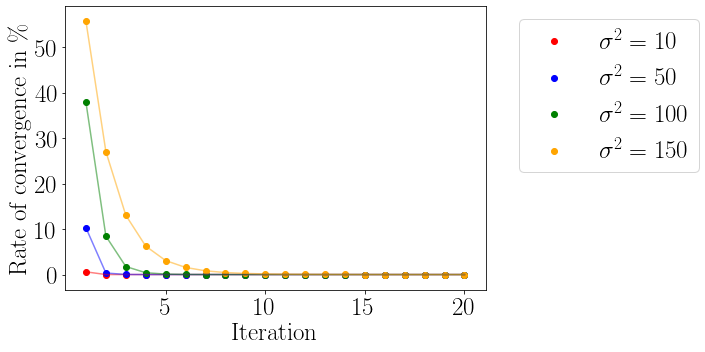

In [12]:
# average value of convergance rate through iterations of gravity model
plt.figure(figsize=(10,5))
plt.scatter(1 + np.arange(20), \
            100*mean_10_kvg,\
            c= 'red', label = r'$\sigma^2 = 10$')
plt.plot(1 + np.arange(20), \
            100*mean_10_kvg,\
            c= 'red', alpha = 0.5)

plt.scatter(1 + np.arange(20),\
            100*mean_50_kvg,\
            c= 'blue', label = r'$\sigma^2 = 50$')
plt.plot(1 + np.arange(20),\
            100*mean_50_kvg,\
            c= 'blue', alpha = 0.5)

plt.scatter(1 +  np.arange(20),\
           100*mean_100_kvg,\
           c= 'green', label = r'$\sigma^2 = 100$')
plt.plot(1 +  np.arange(20),\
           100*mean_100_kvg,\
           c= 'green', alpha = 0.5)

plt.scatter(1 + np.arange(20),\
           100*mean_150_kvg,\
           c= 'orange', label = r'$\sigma^2 = 150$')
plt.plot(1 + np.arange(20),\
           100*mean_150_kvg,\
           c= 'orange', alpha = 0.5)

plt.xlabel(r"Iteration", size = 25)
plt.ylabel(r"Rate of convergence in \%", size = 25)
#xticks = [5,10,15,20]
#yticks = [0, 10, 20, 30, 40, 50, 60]
plt.yticks(fontsize = 25)
plt.xticks(ticks = [5, 10, 15, 20], fontsize = 25)
#ax.set_yticklabels(["$%.0f$" % y for y in yticks], fontsize=15); # use LaTeX formatted labels
#ax.set_xticklabels(["$%.0f$" % x for x in xticks], fontsize=15)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=25)
plt.tight_layout()
#plt.savefig('rate_of_convergence.png')

In [13]:
# standard deviation of convergence rate
odchylky_10 = np.std(m_10_kvg, axis=0)
odchylky_50 = np.std(m_50_kvg, axis=0)
odchylky_100 = np.std(m_100_kvg, axis=0)
odchylky_150 = np.std(m_150_kvg, axis=0)

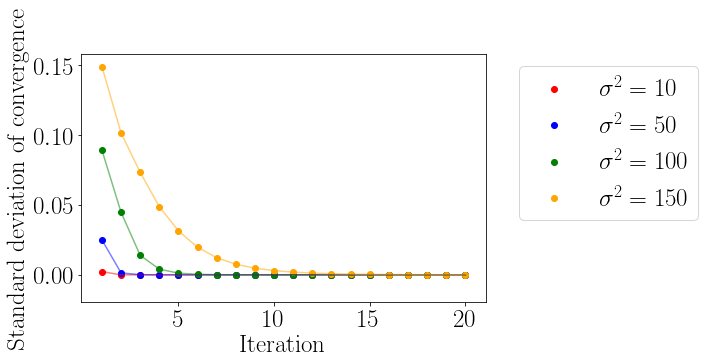

In [14]:
# standard deviation of convergance rate through iterations of gravity model
plt.figure(figsize=(10,5))
plt.scatter(1 + np.arange(20), \
        odchylky_10,\
            c= 'red', label = r'$\sigma^2 = 10$')
plt.plot(1 + np.arange(20), \
        odchylky_10,\
            c= 'red', alpha = 0.5)

plt.scatter(1 + np.arange(20),
         odchylky_50,\
         c= 'blue', label = r'$\sigma^2 = 50$')
plt.plot(1 + np.arange(20),
         odchylky_50,\
         c= 'blue', alpha = 0.5)

plt.scatter(1 + np.arange(20),
         odchylky_100,\
         c= 'green', label = r'$\sigma^2 = 100$')
plt.plot(1 + np.arange(20),
         odchylky_100,\
         c= 'green', alpha = 0.5)

plt.scatter(1 + np.arange(20),
         odchylky_150,\
         c= 'orange', label = r'$\sigma^2 = 150$')
plt.plot(1 + np.arange(20),
         odchylky_150,\
         c= 'orange', alpha = 0.5)

#plt.title(r"Smerodajna odchylka konvergencie po iteráciách pre rôzne sigmy", size = 20)
plt.xlabel(r"Iteration", fontsize = 25)
plt.ylabel(r"Standard deviation of convergence", fontsize = 25)
xticks = [5,10,15,20]
yticks = [0, 0.05, 0.1, 0.15]
plt.yticks(ticks = yticks, fontsize = 25)
plt.xticks(ticks = xticks, fontsize = 25)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=25)
plt.tight_layout()
#plt.savefig('standard_deviation_kvg.png')

In [15]:
# mean value of entropy
mean_10_e = np.mean(m_10_entropia, axis=0)
mean_50_e = np.mean(m_50_entropia, axis=0)
mean_100_e = np.mean(m_100_entropia, axis=0)
mean_150_e = np.mean(m_150_entropia, axis=0)

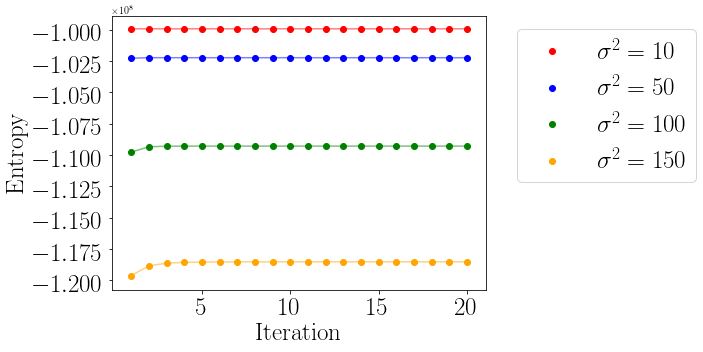

In [16]:
# average value of entropy through iterations of gravity model
plt.figure(figsize=(10,5))
plt.scatter( 1 + np.arange(20),\
            mean_10_e,\
            c= 'red', label = '$\sigma^2 = 10$')
plt.plot( 1 + np.arange(20),\
            mean_10_e,\
            c= 'red', alpha = 0.5)

plt.scatter( 1 + np.arange(20),\
            mean_50_e,\
            c= 'blue', label = '$\sigma^2 = 50$')
plt.plot( 1 + np.arange(20),\
            mean_50_e,\
            c= 'blue', alpha = 0.5)

plt.scatter( 1 + np.arange(20),\
            mean_100_e,\
            c= 'green', label = '$\sigma^2 = 100$')
plt.plot( 1 + np.arange(20),\
            mean_100_e,\
            c= 'green', alpha = 0.5)

plt.scatter( 1 + np.arange(20),\
            mean_150_e,\
            c= 'orange', label = '$\sigma^2 = 150$')
plt.plot( 1 + np.arange(20),\
            mean_150_e,\
            c= 'orange', alpha = 0.5)

#plt.title(r"Entropia po iteráciách pre rôzne sigmy", size = 20)
plt.xlabel(r"Iteration", size = 25)
plt.ylabel(r"Entropy", size = 25)
xticks = [5,10,15,20]
#yticks = [-1.2*10**8, -1.15*10**8, -1.1*10**8, -1.05*10**8, -1*10**8]
#ax.set_yticks(yticks, labels = [-1.2*10**8, -1.15*10**8, -1.1*10**8, -1.05*10**8, -1*10**8])
plt.xticks(ticks = xticks, fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=25)
plt.tight_layout()
#plt.savefig('entropy_gravity.png')

In [17]:
#standard deviation of entropy
odchylky_10_e = np.std(m_10_entropia, axis=0)
odchylky_50_e = np.std(m_50_entropia, axis=0)
odchylky_100_e = np.std(m_100_entropia, axis=0)
odchylky_150_e = np.std(m_150_entropia, axis=0)

In [18]:
odchylky_10_e/mean_10_e

array([-0.03005961, -0.03005863, -0.03005863, -0.03005863, -0.03005863,
       -0.03005863, -0.03005863, -0.03005863, -0.03005863, -0.03005863,
       -0.03005863, -0.03005863, -0.03005863, -0.03005863, -0.03005863,
       -0.03005863, -0.03005863, -0.03005863, -0.03005863, -0.03005863])

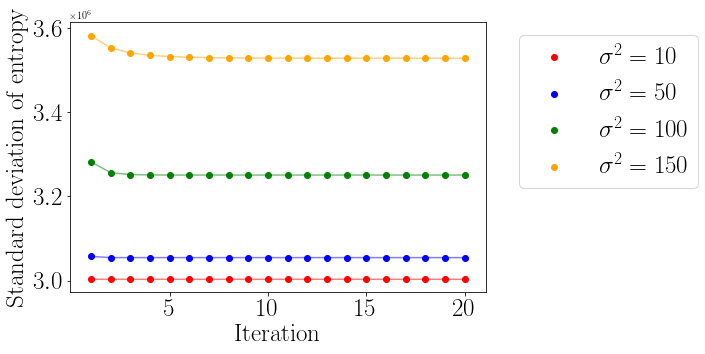

In [19]:
# standard deviation of entropy through iterations of gravity model
plt.figure(figsize=(10,5))
plt.scatter(1 + np.arange(20), \
        odchylky_10_e,\
            c= 'red', label = r'$\sigma^2 = 10$')
plt.plot(1 + np.arange(20), \
        odchylky_10_e,\
            c= 'red', alpha = 0.5)

plt.scatter(1 + np.arange(20),\
         odchylky_50_e,\
         c= 'blue', label = r'$\sigma^2 = 50$')
plt.plot(1 + np.arange(20),\
         odchylky_50_e,\
         c= 'blue', alpha = 0.5)

plt.scatter(1 + np.arange(20),\
         odchylky_100_e,\
         c= 'green', label = r'$\sigma^2 = 100$')
plt.plot(1 + np.arange(20),\
         odchylky_100_e,\
         c= 'green', alpha = 0.5)

plt.scatter(1 + np.arange(20),\
         odchylky_150_e,\
         c= 'orange', label = r'$\sigma^2 = 150$')
plt.plot(1 + np.arange(20),\
         odchylky_150_e,\
         c= 'orange', alpha = 0.5)

#plt.title(r"Smerodajna odchylka entropie po iteráciách pre rôzne sigmy", size = 20)
plt.xlabel(r"Iteration", size = 25)
plt.ylabel(r"Standard deviation of entropy", size = 25)
plt.xticks(ticks = np.array([5,10,15,20]), fontsize=25)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.yticks(ticks = np.array([0.3*10**7, 0.32*10**7, 0.34*10**7, 0.36*10**7]), fontsize=25)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=25)
plt.tight_layout()
#plt.savefig('standar_deviaton_entropy.png')